In [226]:
import pandas as pd
import numpy as np
from torchvision import  transforms , models
from torch.utils.data import Dataset , DataLoader 
import torch.nn as nn
import matplotlib.pyplot as plt    
import torch
import os
from tqdm import tqdm
from PIL import Image


In [227]:
class Facekeypoint(Dataset):
    def __init__(self,csv_path,split):
        super(Facekeypoint).__init__()
        self.csv_path=csv_path
        self.split=split
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.df=pd.read_csv(self.csv_path)
        self.normal=transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )


    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        img,org_img_size=self.get_img(index)
        keypoints=self.get_keypoints(index,org_img_size)
        return img,keypoints
    
    def get_img(self,index):
        img_path=os.path.join(os.getcwd(),self.split,self.df.iloc[index,0]) #Get image at index and its 0th column
        img=Image.open(img_path).convert('RGB') #Read image turn to RGB
        org_img_size=img.size 

        img=img.resize((224,224)) #Resize image to make it 224x224 for all images
        img=np.array(img)/255.0 #Normalize image
        img=torch.tensor(img).permute(2,0,1).float() # Change structure to match requirement of pytorch
        img=self.normal(img) #Normalize image more

        return img.to(self.device),org_img_size#Send image to GPU or CPU

    def get_keypoints(self,index,org_img_size):
        keypoints=self.df.iloc[index,1:].to_numpy().astype(np.float32)
        kp_x=keypoints[0::2]/org_img_size[0]
        kp_y=keypoints[1::2]/org_img_size[1]
        kp=np.concatenate([kp_x,kp_y])

        return torch.tensor(kp).to(self.device)
    

    def load_img(self,index):
        img_path=os.path.join(os.getcwd(),self.split,self.df.iloc[index,0])
        img=Image.open(img_path).convert('RGB')
        img=img.resize((224,224))
        return np.asarray(img)/255.0
        

In [228]:
print(os.getcwd())

c:\Users\sinju\Documents\Handsign_kp\notebook


## Visualize

In [229]:
data=Facekeypoint(r'data\training_frames_keypoints.csv',r'data\training')
imagedata,kp=data[0]
img=data.load_img(0)

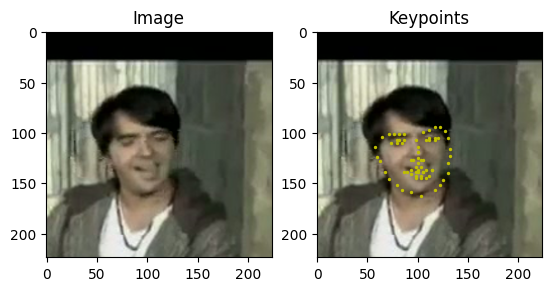

In [230]:

plt.subplot(1,2,1)
plt.title('Image')
plt.imshow(img)

plt.subplot(1,2,2)
plt.title('Keypoints')
plt.imshow(img)
plt.scatter(kp[:68]*224,kp[68:]*224,c='y',s=2)

## Training

In [231]:
train=Facekeypoint(r'data\training_frames_keypoints.csv',r'data\training')
training_data=DataLoader(train,batch_size=16,shuffle=True)

test=Facekeypoint(r'data\test_frames_keypoints.csv',r'data\test')
testing_data=DataLoader(test,batch_size=16,shuffle=False)

c:\Users\sinju\Documents\Handsign_kp\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sinju\Documents\Handsign_kp\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [233]:
def get_model(device):
    vgg16_model=models.vgg16(pretrained=True)
    vgg16_model.eval()
    for layers in vgg16_model.parameters():
        layers.requires_grad=False
    vgg16_model.avgpool=nn.Sequential(
        nn.Conv2d(512,512,3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    vgg16_model.classifier=nn.Sequential(
        nn.Linear(2048,512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(512,136),
        nn.Sigmoid()
    )
    return vgg16_model.to(device)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16_model=get_model(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [234]:
def train_batch(img,kps,vgg16_model,optimizer,criterion):
    vgg16_model.train()
    optimizer.zero_grad()

    #forward_pass
    pred=vgg16_model(img)
    loss=criterion(pred,kps)

    #backward pass
    loss.backward()
    optimizer.step()

    return loss

        

In [235]:
@torch.no_grad()
def model_test(img,kps,vgg16_model,criterion):
    vgg16_model.eval()
    pred=vgg16_model(img)
    loss=criterion(pred,kps)

    return loss

In [236]:
optimizer=torch.optim.Adam(vgg16_model.parameters(),lr=0.001)
criterion=nn.L1Loss()
n_epoch=10

In [237]:
train_loss=[]
test_loss=[]

for epoch in range(1,n_epoch+1):
    epoch_train_loss,epoch_test_loss=0,0


    for img,kps in tqdm(training_data,desc=f'Training {epoch} of {n_epoch}'):
        loss=train_batch(img,kps,vgg16_model,optimizer,criterion)
        epoch_train_loss+=loss.item()
    epoch_train_loss/=len(training_data)
    train_loss.append(epoch_train_loss)


    for img,kps in tqdm(testing_data,desc=f'Testing {epoch} of {n_epoch}'):
        loss=model_test(img,kps,vgg16_model,criterion)
        epoch_test_loss+=loss.item()
    epoch_test_loss/=len(testing_data)
    test_loss.append(epoch_test_loss)




    print(f'Epoch {epoch}/{n_epoch} : Train Loss : {epoch_train_loss} Test Loss : {epoch_test_loss}')






Testing 1 of 10: 100%|██████████| 49/49 [01:27<00:00,  1.80s/it]


Epoch 1/10 : Train Loss : 0.04988295044149122 Test Loss : 0.03328579652826397


Testing 2 of 10: 100%|██████████| 49/49 [01:26<00:00,  1.76s/it]


Epoch 2/10 : Train Loss : 0.03882274853091361 Test Loss : 0.026083867388720414


Testing 3 of 10: 100%|██████████| 49/49 [01:23<00:00,  1.70s/it]


Epoch 3/10 : Train Loss : 0.03410027401890898 Test Loss : 0.02636535051373803


Testing 4 of 10: 100%|██████████| 49/49 [01:22<00:00,  1.68s/it]


Epoch 4/10 : Train Loss : 0.03238896036752358 Test Loss : 0.02689902727701226


Testing 5 of 10: 100%|██████████| 49/49 [01:23<00:00,  1.69s/it]


Epoch 5/10 : Train Loss : 0.030762214024770095 Test Loss : 0.023091074383380462


Testing 6 of 10: 100%|██████████| 49/49 [01:22<00:00,  1.68s/it]


Epoch 6/10 : Train Loss : 0.029511655504871073 Test Loss : 0.0232160891957429


Testing 7 of 10: 100%|██████████| 49/49 [01:21<00:00,  1.67s/it]


Epoch 7/10 : Train Loss : 0.029617978938026913 Test Loss : 0.02273951721738796


Testing 8 of 10: 100%|██████████| 49/49 [01:22<00:00,  1.69s/it]


Epoch 8/10 : Train Loss : 0.028892609449575574 Test Loss : 0.02279842542294337


Testing 9 of 10: 100%|██████████| 49/49 [01:21<00:00,  1.66s/it]


Epoch 9/10 : Train Loss : 0.029073296209222162 Test Loss : 0.023765221580254788


Training 10 of 10:  98%|█████████▊| 213/217 [06:03<00:06,  1.71s/it]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sinju\\Documents\\Handsign_kp\\notebook\\data\\training\\Baburam_Bhattari_00.jpg'

In [ ]:
torch.save(vgg16_model, 'vgg16_model.pth')


In [ ]:
epochs = np.arange(1, n_epoch+1)

plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.title("Training and Test Loss Curve Over Epochs")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()
plt.show()

In [ ]:
img = test.load_img(0)

plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.title('Original Image')
plt.imshow(img)

plt.subplot(122)
plt.title("Image with Facial Keypoints")
plt.imshow(img)

img, _ = test[0]
kp_s = vgg16_model(img[None]).flatten().detach().cpu()
kp_s = kp_s.to('cpu')
plt.scatter(kp_s[:68] * 224, kp_s[68:] * 224, c='y',s = 2)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-0.4739, -0.4397, -0.4568,  ..., -0.1314, -0.1314, -0.1486],
          [-0.4739, -0.4397, -0.4054,  ..., -0.1314, -0.1314, -0.1486],
          [-0.4568, -0.4054, -0.3712,  ..., -0.1143, -0.1143, -0.1314]],
 
         [[-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          ...,
          [-0.2850, -0.2500, -0.2675,  ..., -0.0049, -0.0049, -0.0224],
          [-0.2850, -0.2500, -0.2150,  ..., -0.0049, -0.0049, -0.0224],
          [-0.2675, -0.2150, -0.1800,  ...,  0.0126,  0.0126, -0.0049]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,